# Classification automatique de questions (sklearn)

## 1. Nettoyage du texte

In [45]:
import pandas as pd

import nltk
from bs4 import BeautifulSoup
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis

### 1.1 Création des fonctions

In [2]:
def preprocess(text) :

    """" Preprocessing :
suppression du code du texte que l'on stocke dans une nouvelle colonne 'Code'
suppression des url et du contenu des balises autres que p (script, alt, ...)
suppression des balises html
passage en minuscule
suppression de la ponctuation et des chiffres """
    
    soup = BeautifulSoup(text)
    
    if soup.find("code") :        
        code = soup.find("code").get_text()
        soup.find('code').clear()
    text_wo_tags = soup.get_text()
    
    text_lower = text_wo_tags.lower()
    text_clean = text_lower
    for character in text_clean :
        if character in punctuation or character.isdigit() :
            text_clean = text_clean.replace(character, '')
    return text_clean


def tokenize(text) :

    # Tokenizer :
# décomposition de chaque phrase en une suite de mots
    
    text_token = nltk.tokenize.word_tokenize(text)
    return text_token


stop_words = nltk.corpus.stopwords.words("english")

def stopwfilter(text) :

    # Stopwords
# suppression des mots qui ne portent pas de sens (pronoms, prépositions, ...)
    
    clean_text = [i for i in text if i not in stop_words]
    return clean_text


def lemmatize(text) :
    
    # Lemmatizer
# radicalisation des mots conjugués ou accordés
    
    tmp = text
    for word in tmp :
        if word in punctuation or len(word) < 2 :
            tmp.remove(word)
    lem = nltk.stem.WordNetLemmatizer()
    text_lem = [lem.lemmatize(word) for word in tmp]
    return ' '.join(text_lem)


def cleantokenize(text) :

    # Passage de toutes les fonctions précédentes
    
    text = preprocess(text)
    text = tokenize(text)
    text = stopwfilter(text)
    text = lemmatize(text)
    return text

### 1.2 Nettoyage

In [3]:
data = pd.read_csv("data.csv")
data = data.drop(columns = data.columns[0])

In [4]:
corpus = data['Title'].apply(cleantokenize)

/opt/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [5]:
print("Documents bruts :")
print("")
print(data['Title'].head(3))
print("---------------------------------------")
print("Documents nettoyés :")
print("")
print(corpus.head(3))

Documents bruts :

0         Making a particle follow a path in spriteKit
1    Handling the window closing event with WPF / M...
2    How to find the cause of a malloc "double free...
Name: Title, dtype: object
---------------------------------------
Documents nettoyés :

0                making particle follow path spritekit
1    handling window closing event wpf mvvm light t...
2                  find cause malloc double free error
Name: Title, dtype: object


In [6]:
corpus_sample = corpus.sample(frac = 0.1)

In [7]:
corpus_sample = corpus_sample.tolist()

## 2. Extraction de features

### 2.1 Bag of words (CountVectorizer)

#### 2.1.1 Modélisation

In [8]:
cv = CountVectorizer()
X = cv.fit_transform(corpus_sample)

In [9]:
count = pd.DataFrame(X.todense().tolist(), columns = cv.get_feature_names_out())
print("Shape : ", count.shape)
count

,aab,aar,abandoned,abbreviated,abbreviation,abis,able,abort,abpeoplepickernavigationcontroller,absolute,...,zipfiletestzip,zipped,zlib,zone,zoom,zooming,zurb,zuul,zxing,äüö
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4226,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4227,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4228,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2.1.2 Réduction de dimensions (LDA optimisée par GridSearchCV)

In [10]:
search_params = {'n_components': [3, 5, 10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

In [11]:
lda = LatentDirichletAllocation()

In [12]:
grid = GridSearchCV(lda, param_grid = search_params)

In [13]:
grid.fit(count)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [14]:
print(grid.best_params_)

{'learning_decay': 0.9, 'n_components': 10}


In [15]:
lda = LatentDirichletAllocation(learning_decay = 0.9, n_components = 10, random_state = 42)

In [16]:
lda.fit(count)

LatentDirichletAllocation(learning_decay=0.9, random_state=42)

In [61]:
lda_results = pd.DataFrame(lda.components_, columns = cv.get_feature_names_out())
print("Shape : ", lda_results.shape)
lda_results.head(3)

Shape :  (10, 5845)


,aab,aar,abandoned,abbreviated,abbreviation,abis,able,abort,abpeoplepickernavigationcontroller,absolute,...,zipfiletestzip,zipped,zlib,zone,zoom,zooming,zurb,zuul,zxing,äüö
0,0.1,0.1,0.1,0.1,0.10000,0.1,0.100000,0.1,1.1,0.100000,...,0.1,0.1,0.1,0.1,3.100063,1.1,0.1,0.1,1.1,0.1
1,0.1,0.1,0.1,0.1,0.10000,0.1,1.099971,0.1,0.1,0.100000,...,0.1,0.1,1.1,0.1,0.100000,0.1,0.1,0.1,0.1,0.1
2,0.1,0.1,0.1,0.1,1.09997,0.1,0.100000,0.1,0.1,0.100015,...,0.1,0.1,0.1,0.1,1.099972,0.1,0.1,1.1,0.1,0.1


In [62]:
lda_results

,aab,aar,abandoned,abbreviated,abbreviation,abis,able,abort,abpeoplepickernavigationcontroller,absolute,...,zipfiletestzip,zipped,zlib,zone,zoom,zooming,zurb,zuul,zxing,äüö
0,0.1,0.1,0.1,0.1,0.10000,0.1,0.100000,0.1,1.1,0.100000,...,0.1,0.1,0.1,0.1,3.100063,1.1,0.1,0.1,1.1,0.1
1,0.1,0.1,0.1,0.1,0.10000,0.1,1.099971,0.1,0.1,0.100000,...,0.1,0.1,1.1,0.1,0.100000,0.1,0.1,0.1,0.1,0.1
2,0.1,0.1,0.1,0.1,1.09997,0.1,0.100000,0.1,0.1,0.100015,...,0.1,0.1,0.1,0.1,1.099972,0.1,0.1,1.1,0.1,0.1
3,0.1,0.1,0.1,0.1,0.10000,1.1,0.100000,0.1,0.1,0.100000,...,0.1,0.1,0.1,0.1,0.100000,0.1,0.1,0.1,0.1,0.1
4,0.1,0.1,0.1,0.1,0.10000,0.1,0.100000,0.1,0.1,0.100000,...,0.1,1.1,0.1,0.1,0.100000,0.1,0.1,0.1,0.1,0.1
5,0.1,0.1,1.1,0.1,0.10003,0.1,0.100000,1.1,0.1,0.100000,...,1.1,0.1,0.1,0.1,0.100000,0.1,0.1,0.1,0.1,1.1
6,0.1,0.1,0.1,0.1,0.10000,0.1,1.100002,0.1,0.1,0.100000,...,0.1,0.1,0.1,0.1,1.099985,0.1,0.1,0.1,0.1,0.1
7,1.1,0.1,0.1,0.1,0.10000,0.1,1.099996,0.1,0.1,2.099996,...,0.1,0.1,0.1,0.1,1.099980,0.1,1.1,0.1,0.1,0.1
8,0.1,0.1,0.1,0.1,0.10000,0.1,0.100000,0.1,0.1,0.100000,...,0.1,0.1,0.1,0.1,0.100000,0.1,0.1,0.1,0.1,0.1
9,0.1,2.1,0.1,1.1,0.10000,0.1,2.100031,0.1,0.1,1.099990,...,0.1,0.1,0.1,1.1,0.100000,0.1,0.1,0.1,0.1,0.1


In [57]:
topicwords = []
for i in range(len(lda_results)) :
    topicwords.append(lda_results.iloc[i].sort_values(ascending = False)[:11].index.tolist())

#### 2.1.3 Visualisation en topics

In [58]:
pd.DataFrame(topicwords)

,0,1,2,3,4,5,6,7,8,9,10
0,sql,java,mvc,column,table,value,aspnet,io,use,select,using
1,error,file,core,data,python,time,read,java,json,work,list
2,javascript,studio,visual,android,code,using,function,io,error,value,view
3,file,using,memory,request,android,project,use,get,error,data,spring
4,using,array,way,input,field,io,method,html,template,python,class
5,test,use,python,class,jquery,aspnet,unit,property,net,way,using
6,php,work,image,using,get,object,python,use,file,user,linux
7,using,string,key,view,multiple,google,interface,json,rail,make,image
8,application,server,spring,using,app,sql,create,use,rail,working,io
9,android,using,window,change,file,library,image,without,install,python,color


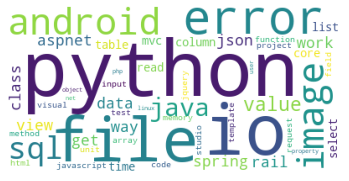

In [43]:
wordcloud = WordCloud(background_color = 'white', stopwords = ['use', 'using'], max_words = 50).generate(
    ' '.join(pd.Series(topicwords).explode().tolist()))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()